In [1]:
test_folder_path="/ssd7/ICCV2025_COVID19/test_fixed"

## Test 資料集處理

In [ ]:
"""
# ============================================================================
# Test 資料前處理：創建乾淨的 test_fixed 資料夾
# 處理 test 資料結構：ct_scan_0 到 ct_scan_1487 -> *.jpg
# ============================================================================

import os
import shutil
from pathlib import Path

def create_clean_test_dataset(source_path, target_path):
    """
    清理 test 資料集，過濾掉有問題的檔案
    
    資料結構:
    test/
    ├── ct_scan_0/        # 包含 *.jpg
    ├── ct_scan_1/
    ├── ct_scan_2/
    └── ...
    ├── ct_scan_1487/
    
    Args:
        source_path: 原始 test 路徑
        target_path: 目標 test_fixed 路徑
    """
    
    source_path = Path(source_path)
    target_path = Path(target_path)
    
    print(f"開始處理 Test 資料集...")
    print(f"來源路徑: {source_path}")
    print(f"目標路徑: {target_path}")
    
    # 創建根目錄
    if target_path.exists():
        print(f"目標資料夾已存在，清空中...")
        shutil.rmtree(target_path)
    target_path.mkdir(exist_ok=True)
    
    total_copied = 0
    total_skipped = 0
    total_ct_folders = 0
    valid_ct_folders = 0
    
    print(f"\n{'='*50}")
    print(f"處理 CT Scan 資料夾")
    print(f"{'='*50}")
    
    # 遍歷所有 ct_scan_i 資料夾
    ct_folders = sorted([d for d in source_path.iterdir() 
                        if d.is_dir() and d.name.startswith('ct_scan_')])
    
    total_ct_folders = len(ct_folders)
    print(f"找到 {total_ct_folders} 個 CT Scan 資料夾")
    
    for i, ct_folder in enumerate(ct_folders):
        if i % 100 == 0:  # 每處理 100 個資料夾顯示進度
            print(f"處理進度: {i}/{total_ct_folders} ({i/total_ct_folders*100:.1f}%)")
        
        target_ct_folder = target_path / ct_folder.name
        target_ct_folder.mkdir(exist_ok=True)
        
        copied_in_folder = 0
        skipped_in_folder = 0
        
        # 處理該 ct_scan 資料夾中的所有 jpg 檔案
        jpg_files = list(ct_folder.glob('*.jpg'))
        
        for jpg_file in jpg_files:
            # 跳過 macOS 系統檔案
            if jpg_file.name.startswith('._'):
                skipped_in_folder += 1
                continue
            
            # 檢查檔案大小（系統檔案通常很小）
            try:
                file_size = jpg_file.stat().st_size
                if file_size < 10000:  # 小於 10KB 的檔案可能有問題
                    if i < 10:  # 只在前 10 個資料夾顯示詳細信息
                        print(f"    跳過小檔案: {ct_folder.name}/{jpg_file.name} ({file_size} bytes)")
                    skipped_in_folder += 1
                    continue
                
                # 複製正常檔案
                target_file = target_ct_folder / jpg_file.name
                shutil.copy2(jpg_file, target_file)
                copied_in_folder += 1
                
            except Exception as e:
                print(f"    錯誤處理檔案 {jpg_file}: {e}")
                skipped_in_folder += 1
                continue
        
        total_copied += copied_in_folder
        total_skipped += skipped_in_folder
        
        if copied_in_folder > 0:
            valid_ct_folders += 1
            if i < 10:  # 只在前 10 個資料夾顯示詳細信息
                print(f"  ✅ {ct_folder.name}: {copied_in_folder} 個檔案 "
                      f"(跳過 {skipped_in_folder} 個)")
        else:
            if i < 10:  # 只在前 10 個資料夾顯示詳細信息
                print(f"  ⚠️  {ct_folder.name}: 沒有有效檔案")
    
    print(f"\n{'='*50}")
    print(f"處理完成!")
    print(f"{'='*50}")
    print(f"總 CT 資料夾數: {total_ct_folders}")
    print(f"有效 CT 資料夾數: {valid_ct_folders}")
    print(f"總共複製圖片: {total_copied} 個")
    print(f"總共跳過檔案: {total_skipped} 個")
    print(f"平均每個 CT 資料夾: {total_copied/valid_ct_folders:.1f} 張圖片" if valid_ct_folders > 0 else "")
    
    return total_copied, total_skipped, valid_ct_folders

def verify_clean_test_dataset(dataset_path):
    """
    驗證清理後的 test 資料集結構和內容
    """
    dataset_path = Path(dataset_path)
    
    print(f"\n{'='*50}")
    print(f"驗證 Test 資料集: {dataset_path}")
    print(f"{'='*50}")
    
    if not dataset_path.exists():
        print(f"⚠️  資料集路徑不存在: {dataset_path}")
        return
    
    # 檢查 ct_scan 資料夾
    ct_folders = sorted([d for d in dataset_path.iterdir() 
                        if d.is_dir() and d.name.startswith('ct_scan_')])
    
    total_images = 0
    empty_folders = 0
    
    print(f"📁 找到 {len(ct_folders)} 個 CT Scan 資料夾")
    
    # 統計圖片數量
    for ct_folder in ct_folders:
        jpg_count = len(list(ct_folder.glob('*.jpg')))
        total_images += jpg_count
        if jpg_count == 0:
            empty_folders += 1
    
    print(f"🖼️  總圖片數量: {total_images}")
    print(f"📊 平均每個資料夾: {total_images/len(ct_folders):.1f} 張圖片" if ct_folders else "")
    print(f"⚠️  空資料夾數量: {empty_folders}")
    
    # 檢查資料夾編號連續性
    expected_folders = [f"ct_scan_{i}" for i in range(len(ct_folders))]
    actual_folders = [folder.name for folder in ct_folders]
    
    missing_folders = set(expected_folders) - set(actual_folders)
    if missing_folders:
        print(f"⚠️  缺失的資料夾: {sorted(missing_folders)}")
    else:
        print(f"✅ CT Scan 資料夾編號連續完整")
    
    # 顯示前幾個和後幾個資料夾的詳細信息
    print(f"\n--- 前 5 個資料夾詳情 ---")
    for i in range(min(5, len(ct_folders))):
        folder = ct_folders[i]
        jpg_count = len(list(folder.glob('*.jpg')))
        print(f"  {folder.name}: {jpg_count} 張圖片")
    
    if len(ct_folders) > 10:
        print(f"\n--- 後 5 個資料夾詳情 ---")
        for i in range(max(0, len(ct_folders)-5), len(ct_folders)):
            folder = ct_folders[i]
            jpg_count = len(list(folder.glob('*.jpg')))
            print(f"  {folder.name}: {jpg_count} 張圖片")

# ============================================================================
# 執行 Test 資料前處理
# ============================================================================

if __name__ == "__main__":
    # 設定路徑 - 請根據你的實際路徑修改
    source_data_path = '/ssd7/ICCV2025_COVID19/test'  # 修改為你的 test 資料夾路徑
    target_data_path = '/ssd7/ICCV2025_COVID19/test_fixed'  # 修改為你想要的 test_fixed 路徑
    
    print("開始創建乾淨的 Test 資料集...")
    
    # 創建乾淨的資料集
    try:
        copied_files, skipped_files, valid_folders = create_clean_test_dataset(
            source_data_path, target_data_path)
        
        # 驗證結果
        verify_clean_test_dataset(target_data_path)
        
        print(f"\n🎉 成功! 乾淨的 Test 資料集已創建在: {target_data_path}")
        print("現在可以使用 test_fixed 路徑進行後續處理！")
        
    except Exception as e:
        print(f"❌ 處理過程中發生錯誤: {e}")
        import traceback
        traceback.print_exc()
"""

In [2]:
import os
import gc
import cv2
import math
import copy
import time
import random
import shutil, sys    

import glob
# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2


from sklearn.metrics import f1_score,roc_auc_score


import timm
from timm.models.efficientnet import *

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict


import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from scipy import ndimage

/home/joe1007/miniconda3/envs/e2d/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
test_ct_list=list(glob.glob(os.path.join(test_folder_path, "*"))) 

In [4]:
#取得路徑下所有資料
count=0
data_getcwd = '/ssd7/ICCV2025_COVID19' #base path
full_data_list = [] #儲存所有slice清單
full_path_list = [] #儲存所有CT資料夾清單


for path in Path(os.path.join(data_getcwd,'test')).rglob('*.jpg'): #尋找所有*jpg檔案
    ct_name = str(path.parent).split('/')[-1]
    label = -1
    token_key = '-1'
    full_data_list.append([str(path.parent), ct_name, str(path.name), label, 0, token_key])
    full_path_list.append([str(path.parent), label, 0, token_key])

full_data_list = pd.DataFrame(full_data_list, columns=['path', 'ct_name', 'slice_name','label', 'fold', 'token_key']).reset_index(drop=True) #重置index用於篩選location
full_path_list = pd.DataFrame(full_path_list, columns=['parent_path', 'label', 'fold', 'token_key']).drop_duplicates(subset='parent_path').reset_index(drop=True) #重置index用於篩選location

In [5]:
full_data_list

,path,ct_name,slice_name,label,fold,token_key
0,/ssd7/ICCV2025_COVID19/test/ct_scan_699,ct_scan_699,._48.jpg,-1,0,-1
1,/ssd7/ICCV2025_COVID19/test/ct_scan_699,ct_scan_699,._72.jpg,-1,0,-1
2,/ssd7/ICCV2025_COVID19/test/ct_scan_699,ct_scan_699,6.jpg,-1,0,-1
3,/ssd7/ICCV2025_COVID19/test/ct_scan_699,ct_scan_699,._53.jpg,-1,0,-1
4,/ssd7/ICCV2025_COVID19/test/ct_scan_699,ct_scan_699,69.jpg,-1,0,-1
...,...,...,...,...,...,...
632217,/ssd7/ICCV2025_COVID19/test/ct_scan_1405,ct_scan_1405,._19.jpg,-1,0,-1
632218,/ssd7/ICCV2025_COVID19/test/ct_scan_1405,ct_scan_1405,106.jpg,-1,0,-1
632219,/ssd7/ICCV2025_COVID19/test/ct_scan_1405,ct_scan_1405,._129.jpg,-1,0,-1
632220,/ssd7/ICCV2025_COVID19/test/ct_scan_1405,ct_scan_1405,15.jpg,-1,0,-1


In [6]:
full_path_list

,parent_path,label,fold,token_key
0,/ssd7/ICCV2025_COVID19/test/ct_scan_699,-1,0,-1
1,/ssd7/ICCV2025_COVID19/test/ct_scan_652,-1,0,-1
2,/ssd7/ICCV2025_COVID19/test/ct_scan_697,-1,0,-1
3,/ssd7/ICCV2025_COVID19/test/ct_scan_1468,-1,0,-1
4,/ssd7/ICCV2025_COVID19/test/ct_scan_1451,-1,0,-1
...,...,...,...,...
1507,/ssd7/ICCV2025_COVID19/test/ct_scan_14,-1,0,-1
1508,/ssd7/ICCV2025_COVID19/test/ct_scan_1122,-1,0,-1
1509,/ssd7/ICCV2025_COVID19/test/ct_scan_968,-1,0,-1
1510,/ssd7/ICCV2025_COVID19/test/ct_scan_796,-1,0,-1


張數10 /ssd7/ICCV2025_COVID19/test/ct_scan_750
張數8 /ssd7/ICCV2025_COVID19/test/ct_scan_663
張數8 /ssd7/ICCV2025_COVID19/test/ct_scan_792
張數10 /ssd7/ICCV2025_COVID19/test/ct_scan_662


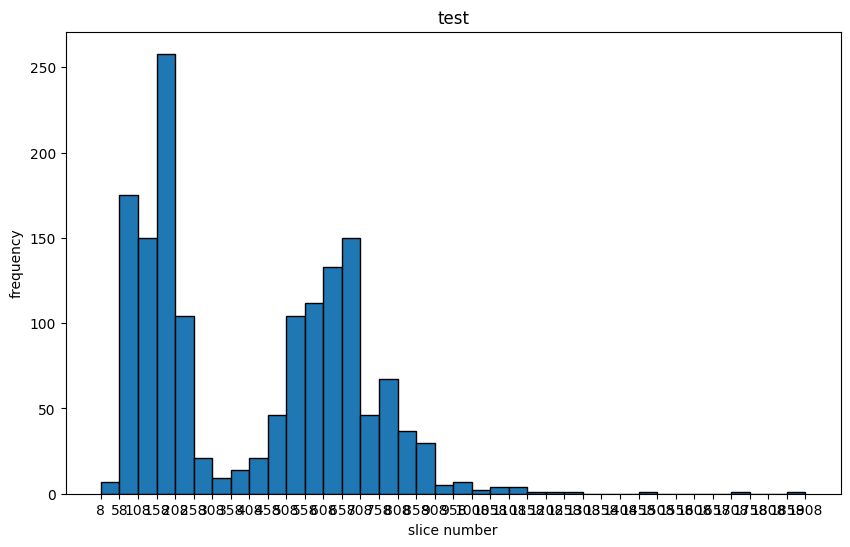

In [7]:
import os
import matplotlib.pyplot as plt

# 初始化张数列表
counts = []
filter_num=20
# 遍历路径，计算每个目录中的文件数
for path_ in full_path_list['parent_path']:
    count = len(os.listdir(path_))
    counts.append(count)
    if count < filter_num:
        print(f"張數{count}", path_)

# 绘制直方图
bin_width = 50  # 或者20，根据需要调整
bins = range(min(counts), max(counts) + bin_width, bin_width)

# 绘制直方图
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=bins, edgecolor='black')
plt.title('test')
plt.xlabel('slice number')
plt.ylabel('frequency')

# 设置X轴的标签
plt.xticks(bins)

plt.show()


In [8]:
len(test_ct_list)

1488

In [12]:
def autocropmin(image, threshold=100, kernsel_size = 10):
        
    img = image.copy()
    
    SIZE = img.shape[0]
    imgfilt = ndimage.minimum_filter(img, size=kernsel_size)
    img_b=np.where(imgfilt<threshold,0,255)
    a=img_b[:,:,0].sum(axis=1)
    a=np.concatenate(([0],a,[0]))

    a_=np.where(a==0)[0]
    mina=a_[np.argmax(a_[1:]-a_[:-1])]
    maxa=a_[np.argmax(a_[1:]-a_[:-1])+1]-1

    b=img_b[:,:,0].sum(axis=0)
    b=np.concatenate(([0],b,[0]))

    b_=np.where(b==0)[0]
    minb=b_[np.argmax(b_[1:]-b_[:-1])]
    maxb=b_[np.argmax(b_[1:]-b_[:-1])+1]-1

    if  mina!=maxa and minb!=maxb:
        imageout=img[mina:maxa,minb:maxb,:]
    else:
        imageout=img

    return imageout

In [7]:
diff_shape_ct_list=[]
for i in tqdm(range(len(test_ct_list))):
    
    tmp_list=list(glob.glob(os.path.join(test_ct_list[i], "*")))
    tmp_shape_set=set()
    for j in range(len(tmp_list)):
    
        str1=tmp_list[j]
        img=cv2.imread(str1)
        
        try:
            tmp_shape_set.add(img.shape)
        except:
            print("bug file")
            continue
        
        img=autocropmin(img)


        str1=str1.replace(test_folder_path,"/ssd7/ICCV2025_COVID19/test_cropped")


        folder_path="/".join(str1.split("/")[:-1])
        if len(tmp_shape_set)!=1:
            shutil.rmtree(folder_path)
            diff_shape_ct_list.append(folder_path.split("/")[-1])
            print(folder_path)
            break
            
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        cv2.imwrite(str1,img)


  2%|▏         | 31/1413 [04:27<2:21:44,  6.15s/it]

/ssd2/ming/2024COVID/test_crop/gbwa1jlx.ajf


 12%|█▏        | 171/1413 [24:09<2:24:17,  6.97s/it]

/ssd2/ming/2024COVID/test_crop/32mwmw5y.zzs


 19%|█▉        | 269/1413 [37:50<2:10:28,  6.84s/it]

/ssd2/ming/2024COVID/test_crop/43evg34y.vsa


 54%|█████▍    | 763/1413 [1:45:39<57:46,  5.33s/it]  

/ssd2/ming/2024COVID/test_crop/21kqbeui.1pz


100%|██████████| 1413/1413 [3:14:47<00:00,  8.27s/it]  


In [21]:
test_folder_path="/ssd7/ICCV2025_COVID19/test_fixed"

for ct in diff_shape_ct_list:
    str1=test_folder_path+"/"+ct
    str2="/ssd7/ICCV2025_COVID19/test_cropped"+ct
    
    tmp_list=list(glob.glob(os.path.join(str1, "*")))
    print(tmp_list)
    print(len(tmp_list))
    last_file=str(len(tmp_list)-1)+".jpg"
    str1=str1+"/"+last_file
    str2=str2+"/"+last_file
    print(str1)
    print(str2)
    img=cv2.imread(str1)
    img=autocropmin(img)
    folder_path="/".join(str2.split("/")[:-1])
    # print(folder_path)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    cv2.imwrite(str2,img)
    print(str2)
    

['/ssd2/ming/2024COVID/test1/21kqbeui.1pz/0.jpg']
1
/ssd2/ming/2024COVID/test1/21kqbeui.1pz/0.jpg
/ssd2/ming/2024COVID/test_crop/21kqbeui.1pz/0.jpg
/ssd2/ming/2024COVID/test_crop/21kqbeui.1pz/0.jpg


In [22]:
len(os.listdir("/ssd7/ICCV2025_COVID19/test_cropped"))

1413

In [ ]:
diff_shape_ct_list=[]
for i in tqdm(range(len(test_ct_list))):
    
    tmp_list=list(glob.glob(os.path.join(test_ct_list[i], "*")))
    
    
    
    tmp_shape_set=set()
    for j in range(len(tmp_list)):
    
        str1=tmp_list[j]
        img=cv2.imread(str1)
        
        try:
            tmp_shape_set.add(img.shape)
        except:
            print("bug file")
            continue
        
        img=autocropmin(img)


        str1=str1.replace(test_folder_path,"/ssd7/ICCV2025_COVID19/test_cropped")


        folder_path="/".join(str1.split("/")[:-1])
        if len(tmp_shape_set)!=1:
            shutil.rmtree(folder_path)
            diff_shape_ct_list.append(folder_path.split("/")[-1])
            print(folder_path)
            break
            
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        cv2.imwrite(str1,img)


In [51]:
all_train_list=[list(glob.glob(os.path.join("/ssd7/ICCV2025_COVID19/test_fixed", "*"))),]

In [53]:
# %%
import os
import gc
import cv2
import math
import copy
import time
import random
import shutil, sys    

from PIL import Image

import glob
# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2


from sklearn.metrics import f1_score,roc_auc_score


import timm
from timm.models.efficientnet import *

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict


import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from scipy import ndimage

def autocropmin(image, threshold=100, kernsel_size = 10):
        
    img = image.copy()
    area=img.shape[0]*img.shape[1]
    SIZE = img.shape[0]
    imgfilt = ndimage.minimum_filter(img, size=kernsel_size)
    img_b=np.where(imgfilt<threshold,0,255)
    a=img_b[:,:,0].sum(axis=1)
    a=np.concatenate(([0],a,[0]))

    a_=np.where(a==0)[0]
    mina=a_[np.argmax(a_[1:]-a_[:-1])]
    maxa=a_[np.argmax(a_[1:]-a_[:-1])+1]-1

    b=img_b[:,:,0].sum(axis=0)
    b=np.concatenate(([0],b,[0]))

    b_=np.where(b==0)[0]
    minb=b_[np.argmax(b_[1:]-b_[:-1])]
    maxb=b_[np.argmax(b_[1:]-b_[:-1])+1]-1

    if  mina!=maxa and minb!=maxb:
        imageout=img[mina:maxa,minb:maxb,:]
    else:
        imageout=img
    
    area2=imageout.shape[0]*imageout.shape[1]
    save=(area-area2)/area
    return imageout,img.shape,imageout.shape,area,area2,save

In [55]:
import csv
# 初始化一个列表来收集数据
data_to_save = []

for train_list in all_train_list:
    diff_shape_ct_list = []
    
    for i in tqdm(range(len(train_list))):
        tmp_list=list(glob.glob(os.path.join(train_list[i], "*")))
        tmp_shape_set=set()
        for j in range(len(tmp_list)):

            str1=tmp_list[j]
            img=cv2.imread(str1)

            try:
                tmp_shape_set.add(img.shape)
            except:
                print(str1)
                print("bug file")
                continue

            img,img1,imgout2,area,area2,save=autocropmin(img)
            data_to_save.append([str1, img1, imgout2, area, area2, save])  # 收集数据
            #print([str1, img1, imgout2, area, area2, save])

            
            str1=str1.replace("/test/","/test_cropped/")
            str1=str1.replace("/test/","/test_cropped/")


            folder_path="/".join(str1.split("/")[:-1])

            if len(tmp_shape_set)!=1:
                shutil.rmtree(folder_path)
                diff_shape_ct_list.append(folder_path)
                
                break

            if not os.path.exists(folder_path):
                os.makedirs(folder_path)
            #cv2.imwrite(str1,img)

# CSV 文件保存路径
csv_file_path = '/ssd7/ICCV2025_COVID19/Analysis_test/test_output.csv'

# 将数据写入 CSV 文件
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Path', 'Img1', 'Imgout2', 'Area', 'Area2', 'Save'])  # 写入标题
    for row in data_to_save:
        writer.writerow(row)  # 写入数据行

100%|██████████| 1413/1413 [3:03:56<00:00,  7.81s/it]  


NameError: name 'csv' is not defined

In [56]:


with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Path', 'Img1', 'Imgout2', 'Area', 'Area2', 'Save'])  # 写入标题
    for row in data_to_save:
        writer.writerow(row)  # 写入数据行

In [58]:
csv_file_path = '/ssd7/ICCV2025_COVID19/Analysis_test/test_output.csv'
data_to_save=pd.read_csv(csv_file_path)

In [59]:
data_to_save = data_to_save.values.tolist()
data_to_save

[['/ssd2/ming/2024COVID/test/11mmey0x.3c4/211.jpg',
  '(512, 512, 3)',
  '(347, 460, 3)',
  262144,
  159620,
  0.3910980224609375],
 ['/ssd2/ming/2024COVID/test/11mmey0x.3c4/54.jpg',
  '(512, 512, 3)',
  '(316, 486, 3)',
  262144,
  153576,
  0.414154052734375],
 ['/ssd2/ming/2024COVID/test/11mmey0x.3c4/98.jpg',
  '(512, 512, 3)',
  '(286, 489, 3)',
  262144,
  139854,
  0.4664993286132812],
 ['/ssd2/ming/2024COVID/test/11mmey0x.3c4/165.jpg',
  '(512, 512, 3)',
  '(328, 474, 3)',
  262144,
  155472,
  0.40692138671875],
 ['/ssd2/ming/2024COVID/test/11mmey0x.3c4/210.jpg',
  '(512, 512, 3)',
  '(347, 460, 3)',
  262144,
  159620,
  0.3910980224609375],
 ['/ssd2/ming/2024COVID/test/11mmey0x.3c4/300.jpg',
  '(512, 512, 3)',
  '(337, 383, 3)',
  262144,
  129071,
  0.5076332092285156],
 ['/ssd2/ming/2024COVID/test/11mmey0x.3c4/13.jpg',
  '(512, 512, 3)',
  '(345, 497, 3)',
  262144,
  171465,
  0.3459129333496094],
 ['/ssd2/ming/2024COVID/test/11mmey0x.3c4/191.jpg',
  '(512, 512, 3)',
  '(

In [60]:
# 提取所有的 Area Ratio 值

print(len(data_to_save))
area_ratios = [item[-1] for item in data_to_save]
Cropped_Area = [item[-2] for item in data_to_save]
Original_Area = [item[-3] for item in data_to_save]
# 计算平均值
average_area_ratio = sum(area_ratios) / len(area_ratios)
remain_area = sum(Cropped_Area) / len(area_ratios)
original_area = sum(Original_Area) / len(area_ratios)
Cropped_area = (sum(Original_Area) - sum(Cropped_Area)) / len(area_ratios)
print(f"Average Area Ratio: {average_area_ratio}")
print(f"Original_area: {original_area}")
print(f"Remain_area: {remain_area}")
print(f"Cropped_area: {Cropped_area}")


436781
Average Area Ratio: 0.45200128969768455
Original_area: 279556.25293224753
Remain_area: 153417.35610065455
Cropped_area: 126138.89683159295


In [3]:
import pickle
with open('/ssd7/ICCV2025_COVID19/processing_test/filter_slice_test_dic1_05_.pickle', 'rb') as f:
    test_dic = pickle.load(f)
print(len(test_dic))

1481


In [4]:
array_data = list(test_dic)
array_data2 = list(test_dic.values())
difference_list = [pair[1] - pair[0] for pair in array_data2]
data_combined = [[array_data[i]] + [difference_list[i]] + [array_data2[i]]for i in range(len(array_data))]

df_train = pd.DataFrame(data_combined, columns=['File Path', 'difference', 'interval'])
df_train['interval'] = df_train['interval'].apply(lambda x: x[:2])
df_train


,File Path,difference,interval
0,/ssd7/ICCV2025_COVID19/test_cropped/ct_scan_0,26,"[15, 41]"
1,/ssd7/ICCV2025_COVID19/test_cropped/ct_scan_1,30,"[13, 43]"
2,/ssd7/ICCV2025_COVID19/test_cropped/ct_scan_10,199,"[89, 288]"
3,/ssd7/ICCV2025_COVID19/test_cropped/ct_scan_100,174,"[88, 262]"
4,/ssd7/ICCV2025_COVID19/test_cropped/ct_scan_1000,160,"[64, 224]"
...,...,...,...
1476,/ssd7/ICCV2025_COVID19/test_cropped/ct_scan_995,162,"[66, 228]"
1477,/ssd7/ICCV2025_COVID19/test_cropped/ct_scan_996,158,"[64, 222]"
1478,/ssd7/ICCV2025_COVID19/test_cropped/ct_scan_997,173,"[85, 258]"
1479,/ssd7/ICCV2025_COVID19/test_cropped/ct_scan_998,166,"[101, 267]"


In [70]:
# 初始化一个列表来收集数据
data_length_save = []

for train_list in all_train_list:
    diff_shape_ct_list = []
    
    for i in tqdm(range(len(train_list))):
        tmp_list=list(glob.glob(os.path.join(train_list[i], "*")))
        tmp_shape_set=set()
        #print(len(tmp_list))
        path = os.path.join(train_list[i])
        path=path.replace("/test/","/test_cropped/")
        data_length_save.append([path,len(tmp_list),[0,len(tmp_list)-1]])
        

# CSV 文件保存路径
csv_file_path = '/ssd7/ICCV2025_COVID19/Analysis_test/test_length_save.csv'

# 将数据写入 CSV 文件
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Slice Path', 'length', 'from', 'to'])  # 写入标题
    for row in data_to_save:
        writer.writerow(row)  # 写入数据行

100%|██████████| 1413/1413 [00:00<00:00, 1821.35it/s]


In [71]:
data_length_save

df_og = pd.DataFrame(data_length_save, columns=['File Path', 'difference', 'interval'])
df_og

,File Path,difference,interval
0,/ssd2/ming/2024COVID/test_crop/11mmey0x.3c4,332,"[0, 331]"
1,/ssd2/ming/2024COVID/test_crop/3kjih4mg.2sr,392,"[0, 391]"
2,/ssd2/ming/2024COVID/test_crop/fld1esi3.gld,390,"[0, 389]"
3,/ssd2/ming/2024COVID/test_crop/0rtjbbvf.3sp,443,"[0, 442]"
4,/ssd2/ming/2024COVID/test_crop/05ewz02d.bpp,308,"[0, 307]"
...,...,...,...
1408,/ssd2/ming/2024COVID/test_crop/qpruvets.yjw,526,"[0, 525]"
1409,/ssd2/ming/2024COVID/test_crop/bcdkdvhy.dqm,256,"[0, 255]"
1410,/ssd2/ming/2024COVID/test_crop/cauqmv43.inz,301,"[0, 300]"
1411,/ssd2/ming/2024COVID/test_crop/0ezb31oo.hfz,293,"[0, 292]"


In [75]:

df_merge = pd.merge(df_og, df_train, on='File Path')

print(sum(df_merge['difference_x'])/1413)
df_merge

309.39702760084924


,File Path,difference_x,interval_x,difference_y,interval_y
0,/ssd2/ming/2024COVID/test_crop/11mmey0x.3c4,332,"[0, 331]",134,"[77, 211]"
1,/ssd2/ming/2024COVID/test_crop/3kjih4mg.2sr,392,"[0, 391]",164,"[98, 262]"
2,/ssd2/ming/2024COVID/test_crop/fld1esi3.gld,390,"[0, 389]",163,"[124, 287]"
3,/ssd2/ming/2024COVID/test_crop/0rtjbbvf.3sp,443,"[0, 442]",189,"[137, 326]"
4,/ssd2/ming/2024COVID/test_crop/05ewz02d.bpp,308,"[0, 307]",122,"[73, 195]"
...,...,...,...,...,...
1408,/ssd2/ming/2024COVID/test_crop/qpruvets.yjw,526,"[0, 525]",231,"[147, 378]"
1409,/ssd2/ming/2024COVID/test_crop/bcdkdvhy.dqm,256,"[0, 255]",96,"[88, 184]"
1410,/ssd2/ming/2024COVID/test_crop/cauqmv43.inz,301,"[0, 300]",118,"[138, 256]"
1411,/ssd2/ming/2024COVID/test_crop/0ezb31oo.hfz,293,"[0, 292]",114,"[79, 193]"


In [76]:
def calculate_averages_fixed(df):
    # Helper function to extract category from the file path
    def extract_category(file_path):
        # Initialize category as an empty string
        category = ''

        # Check for 'train' or 'valid' in the file path
        if 'test' in file_path:
            category = 'test'

        return category
    # Adding a new column for category
    df['Category'] = df['File Path'].apply(extract_category)
    # Calculating the difference ratio
    df['Diff Ratio'] = (df['difference_x'] - df['difference_y']) / df['difference_x']

    # Grouping by category and calculating averages
    averages = df.groupby('Category').agg(
        Average_Difference_X=pd.NamedAgg(column='difference_x', aggfunc='mean'),
        Average_Difference_Y=pd.NamedAgg(column='difference_y', aggfunc='mean'),
        Average_Diff_Ratio=pd.NamedAgg(column='Diff Ratio', aggfunc='mean')
    )

    # Calculating averages for 'total' category
    total_averages = pd.DataFrame(df.agg(
        Average_Difference_X=('difference_x', 'mean'),
        Average_Difference_Y=('difference_y', 'mean'),
        Average_Diff_Ratio=('Diff Ratio', 'mean')
    )).transpose()
    #total_averages.index = ['total']

    # Concatenating the group averages with the total averages
    #all_averages = pd.concat([averages, total_averages])

    return averages

# Assuming df is your DataFrame, you would call the function like this:
averages_df = calculate_averages_fixed(df_merge)
averages_df
# Note: Since I don't have the actual DataFrame, the function isn't executed here.
# You should execute this function in your environment with your DataFrame.


,Average_Difference_X,Average_Difference_Y,Average_Diff_Ratio
Category,,,
test,309.397028,122.994338,0.632
